In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# feature engg

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [4]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df



In [5]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [6]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['dx'] = (train['x_0'] - train['x_1'])
test['dx'] = (test['x_0'] - test['x_1'])
train['dy'] = (train['y_0'] - train['y_1'])
test['dy'] = (test['y_0'] - test['y_1'])
train['dz'] = (train['z_0'] - train['z_1'])
test['dz'] = (test['z_0'] - test['z_1'])

train['r']  = np.sqrt(train['dx']**2+train['dy']**2)
test['r']  = np.sqrt(test['dx']**2+test['dy']**2)

train['phi']  = np.arctan2(train['dy'],train['dx'])
test['phi']  = np.arctan2(test['dy'],test['dx'])

train['phi_deg']  = np.degrees(np.arctan2(train['dy'],train['dx']))
test['phi_deg']  = np.degrees(np.arctan2(test['dy'],test['dx']))

train['z1'] = train['dz']/train['dist']
test['z1'] = test['dz']/test['dist']

train['z2'] = train['dz']/train['r']
test['z2'] = test['dz']/test['r']

train['theta']  = np.arctan2(train['r'],train['dz'])
test['theta']  = np.arctan2(test['r'],test['dz'])

train['theta_deg']  = np.degrees(np.arctan2(train['r'],train['dz']))
test['theta_deg']  = np.degrees(np.arctan2(test['r'],test['dz']))

train['x1'] = train['dx']/train['dist']
test['x1'] = test['dx']/test['dist']

train['x2'] = train['dx']/train['r']
test['x2'] = test['dx']/test['r']

train['y1'] = train['dy']/train['dist']
test['y1'] = test['dy']/test['dist']

train['y2'] = train['dy']/train['r']
test['y2'] = test['dy']/test['r']

train['sin_theta'] = np.sin(train['theta'])
test['sin_theta'] = np.sin(test['theta'])

train['cos_theta'] = np.cos(train['theta'])
test['cos_theta'] = np.cos(test['theta'])

train['sin_phi'] = np.sin(train['phi'])
test['sin_phi'] = np.sin(test['phi'])

train['cos_phi'] = np.cos(train['phi'])
test['cos_phi'] = np.cos(test['phi'])

train['dxy']  = np.sqrt(train['dx']**2+train['dy']**2)
train['dyz']  = np.sqrt(train['dy']**2+train['dz']**2)
train['dxz']  = np.sqrt(train['dx']**2+train['dz']**2)

test['dxy']  = np.sqrt(test['dx']**2+test['dy']**2)
test['dyz']  = np.sqrt(test['dy']**2+test['dz']**2)
test['dxz']  = np.sqrt(test['dx']**2+test['dz']**2)

In [7]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 559.74 Mb (62.5% reduction)
Mem. usage decreased to 296.29 Mb (62.2% reduction)


In [9]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
#     df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
    df['molecule_dxy_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
#     df['molecule_dxy_median'] = df.groupby('molecule_name')['dxy'].transform('median')
    df['molecule_dxy_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
    df['molecule_dxy_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
    df['molecule_dxy_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
    df['molecule_dxz_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
#     df['molecule_dxz_median'] = df.groupby('molecule_name')['dxz'].transform('median')
    df['molecule_dxz_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
    df['molecule_dxz_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
    df['molecule_dxz_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
    df['molecule_dyz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
#     df['molecule_dxy_median'] = df.groupby('molecule_name')['dxy'].transform('median')
    df['molecule_dyz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
    df['molecule_dyz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
    df['molecule_dyz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [10]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 6983.38 Mb (-48.6% reduction)


In [11]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 3751.47 Mb (-48.7% reduction)


In [12]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [13]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [14]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [15]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [16]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type',
'dx',
'dy',
'dz',
'r',
'dxz',
'dyz',
# 'phi',
# 'phi_deg',
# 'z1',
# 'z2',
# 'theta',
# 'theta_deg',
# 'x1',
# 'x2',
# 'y1',
# 'y2',
# 'z1',
# 'z2',
'sin_theta',
'cos_theta',
'sin_phi',
'cos_phi',
# 'molecule_dxy_mean',
# 'molecule_dxy_min',
# 'molecule_dxy_max',

# 'molecule_dxz_mean',
# 'molecule_dxz_min',
# 'molecule_dxz_max',

# 'molecule_dyz_mean',
# 'molecule_dyz_min',
# 'molecule_dyz_max',

# 'molecule_atom_index_0_dist_x_min',
# 'molecule_atom_index_0_dist_x_max',
# 'molecule_atom_index_0_dist_x_mean',
# 'molecule_atom_index_0_dist_x_std',

# 'molecule_atom_index_0_dist_y_min',
# 'molecule_atom_index_0_dist_y_max',
# 'molecule_atom_index_0_dist_y_mean',
# 'molecule_atom_index_0_dist_y_std',
    
# 'molecule_atom_index_0_dist_z_min',
# 'molecule_atom_index_0_dist_z_max',
# 'molecule_atom_index_0_dist_z_mean',
# 'molecule_atom_index_0_dist_z_std',
    
# 'molecule_atom_index_1_dist_x_min',
# 'molecule_atom_index_1_dist_x_max',
# 'molecule_atom_index_1_dist_x_mean',
# 'molecule_atom_index_1_dist_x_std',

# 'molecule_atom_index_1_dist_y_min',
# 'molecule_atom_index_1_dist_y_max',
# 'molecule_atom_index_1_dist_y_mean',
# 'molecule_atom_index_1_dist_y_std',
    
# 'molecule_atom_index_1_dist_z_min',
# 'molecule_atom_index_1_dist_z_max',
# 'molecule_atom_index_1_dist_z_mean',
# 'molecule_atom_index_1_dist_z_std',
    
# 'molecule_type_dist_x_min',
# 'molecule_type_dist_x_max',
# 'molecule_type_dist_x_mean',
# 'molecule_type_dist_x_std',

# 'molecule_type_dist_y_min',
# 'molecule_type_dist_y_max',
# 'molecule_type_dist_y_mean',
# 'molecule_type_dist_y_std',
    
# 'molecule_type_dist_z_min',
# 'molecule_type_dist_z_max',
# 'molecule_type_dist_z_mean',
# 'molecule_type_dist_z_std',
    
# 'molecule_atom_1_dist_x_min',
# 'molecule_atom_1_dist_x_max',
# 'molecule_atom_1_dist_x_mean',
# 'molecule_atom_1_dist_x_std',

# 'molecule_atom_1_dist_y_min',
# 'molecule_atom_1_dist_y_max',
# 'molecule_atom_1_dist_y_mean',
# 'molecule_atom_1_dist_y_std',
    
# 'molecule_atom_1_dist_z_min',
# 'molecule_atom_1_dist_z_max',
# 'molecule_atom_1_dist_z_mean',
# 'molecule_atom_1_dist_z_std',
]


In [17]:
good_columns = [
    'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_max',
    'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_std',
    'y_0',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_1_dist_min',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_z_1_std',
    'molecule_dist_mean',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_1_dist_max',
    'molecule_atom_index_0_y_1_mean_diff',
    'molecule_atom_index_0_dist_mean',
    
    'molecule_dist_max',
    'molecule_atom_1_dist_mean',
    'molecule_atom_index_0_y_1_max_diff',
    'molecule_couples',
    'molecule_atom_1_dist_std_diff',
    'molecule_type_dist_max',
    'molecule_dist_min',
    'molecule_type_dist_min',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_0_dist_mean_div',
    'molecule_atom_index_1_dist_std_diff',
    'atom_index_1',
    'molecule_atom_index_0_dist_max_div',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_type_0_dist_std_diff',
    'molecule_atom_index_0_dist_mean_diff',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_type_dist_mean_diff',
]

In [18]:
good_columns = [
    'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_max',
    'molecule_atom_index_1_dist_min',
    'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_std',
    'dist',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_max',
    'molecule_atom_index_1_dist_mean',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_atom_index_0_dist_max_div',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'atom_0_couples_count',
    'molecule_atom_index_0_dist_min_div',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_0_dist_mean_div',
    'atom_1_couples_count',
    'molecule_atom_index_0_dist_mean_diff',
    'molecule_couples',
    'atom_index_1',
    'molecule_dist_mean',
    'molecule_atom_index_1_dist_max_diff',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_1_dist_mean_diff',
]

In [21]:
list(train.columns)

['id',
 'molecule_name',
 'atom_index_0',
 'atom_index_1',
 'type',
 'scalar_coupling_constant',
 'atom_0',
 'x_0',
 'y_0',
 'z_0',
 'atom_1',
 'x_1',
 'y_1',
 'z_1',
 'dist',
 'dist_x',
 'dist_y',
 'dist_z',
 'dx',
 'dy',
 'dz',
 'r',
 'phi',
 'phi_deg',
 'z1',
 'z2',
 'theta',
 'theta_deg',
 'x1',
 'x2',
 'y1',
 'y2',
 'sin_theta',
 'cos_theta',
 'sin_phi',
 'cos_phi',
 'dxy',
 'dyz',
 'dxz',
 'type_0',
 'type_1',
 'molecule_couples',
 'molecule_dist_mean',
 'molecule_dist_min',
 'molecule_dist_max',
 'molecule_dist_std',
 'atom_0_couples_count',
 'atom_1_couples_count',
 'type_0_couples_count',
 'type_1_couples_count',
 'molecule_dxy_mean',
 'molecule_dxy_min',
 'molecule_dxy_max',
 'molecule_dxy_std',
 'molecule_dxz_mean',
 'molecule_dxz_min',
 'molecule_dxz_max',
 'molecule_dxz_std',
 'molecule_dyz_mean',
 'molecule_dyz_min',
 'molecule_dyz_max',
 'molecule_dyz_std',
 'molecule_atom_index_0_count',
 'molecule_atom_index_1_count',
 'molecule_type_count',
 'molecule_atom_1_count',
 

In [20]:
train.shape

(4658147, 487)

In [922]:
good_columns = [
    'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_max', # 24.42
    'atom_index_0', #24.3873
    'atom_index_1', #16.8178
    'type', #2.18402
#     'atom_0' #2.18402
    'x_0', #2.15712
    'y_0', #2.10615
    'z_0', #2.08603
    'atom_1', #2.08291
    'x_1', #1.99933
    'y_1', #1.95652
    'z_1', #1.89673
    'dist', #1.59632
#     'dist_x', #1.59741
    'dist_y', #1.59478
#     'dist_z', #1.59505
#     'dx', #1.59686
#     'dy', #1.59676
#     'dz', #1.59694
    'r', #1.59287
#     'phi' #1.59777
#     'phi_deg', #1.59672
#     'z1', #1.5956
#     'z2', #1.5991
#     'theta', # 1.59975
#     'theta_deg' #1.59734
#     'x1', #1.59675
#     'x2', #1.59679
#     'y1', #1.59991
#     'y2', #1.5986
#     'sin_theta', #1.59712
#     'cos_theta', #1.5956
#     'sin_phi', #1.5986
#     'cos_phi' #1.59679
#     'dyz', #1.59809
#     'dxz', #1.59695
#     'type_0', #1.59287
#     'type_1', # 1.59287
    'molecule_couples', #1.55716
    'molecule_dist_mean', #1.53695
    'molecule_dist_min', #1.52542
    'molecule_dist_max', #1.51814,
    'molecule_dist_std', #1.51487
    'atom_0_couples_count', #1.46383
    'atom_1_couples_count', #1.43409
#     'type_0_couples_count', #1.4352
    'type_1_couples_count', #1.43095
#     'molecule_dxy_mean', #1.43301
#     'molecule_dxy_min', #1.43352
#     'molecule_dxy_max', # 1.4334
#     'molecule_dxy_std', #1.43231
    'molecule_dyz_mean', #1.43037
#     'molecule_dyz_min', #1.43093
#     'molecule_dyz_max', #1.43452
#     'molecule_dyz_std', #1.43188
    'molecule_dxz_mean', #1.43007
#     'molecule_dxz_min', #1.43067
#     'molecule_dxz_max', #1.43559
#     'molecule_dxz_std', #1.43229
#     'molecule_atom_index_0_count', #1.43007
#     'molecule_atom_index_1_count', #1.43007
#     'molecule_type_count', #1.43007
#     'molecule_atom_1_count', #1.43007
#     'molecule_type_0_count', #1.43007
    'molecule_atom_index_0_x_1_mean', #1.42564
    'molecule_atom_index_0_x_1_mean_diff', #1.42405
#     'molecule_atom_index_0_x_1_mean_div', #1.42634
#     'molecule_atom_index_0_x_1_max', #1.4263
    'molecule_atom_index_0_x_1_max_diff', #1.4161
#     'molecule_atom_index_0_x_1_max_div', #1.4226
#     'molecule_atom_index_0_x_1_std', # 1.42286
#     'molecule_atom_index_0_x_1_std_diff', #1.4253
#     'molecule_atom_index_0_x_1_std_div', #1.42493
    'molecule_atom_index_0_x_1_min',
#     'molecule_atom_index_0_x_1_min_diff',
#     'molecule_atom_index_0_x_1_min_div',
#     'molecule_atom_index_0_y_1_mean',
#     'molecule_atom_index_0_y_1_mean_diff',
#     'molecule_atom_index_0_y_1_mean_div',
#     'molecule_atom_index_0_y_1_max',
#     'molecule_atom_index_0_y_1_max_diff',
#     'molecule_atom_index_0_y_1_max_div',
#     'molecule_atom_index_0_y_1_std',
#     'molecule_atom_index_0_y_1_std_diff',
#     'molecule_atom_index_0_y_1_std_div',
#     'molecule_atom_index_0_y_1_min',
#     'molecule_atom_index_0_y_1_min_diff',
#     'molecule_atom_index_0_y_1_min_div',
#     'molecule_atom_index_0_z_1_mean',
#     'molecule_atom_index_0_z_1_mean_diff',
#     'molecule_atom_index_0_z_1_mean_div',
#     'molecule_atom_index_0_z_1_max',
#     'molecule_atom_index_0_z_1_max_diff',
#     'molecule_atom_index_0_z_1_max_div',
#     'molecule_atom_index_0_z_1_std',
#     'molecule_atom_index_0_z_1_std_diff',
#     'molecule_atom_index_0_z_1_std_div',
#     'molecule_atom_index_0_z_1_min',
#     'molecule_atom_index_0_z_1_min_diff',
#     'molecule_atom_index_0_z_1_min_div',
#     'molecule_atom_index_0_dist_mean',
#     'molecule_atom_index_0_dist_mean_diff',
#     'molecule_atom_index_0_dist_mean_div',
#     'molecule_atom_index_0_dist_max',
#     'molecule_atom_index_0_dist_max_diff',
#     'molecule_atom_index_0_dist_max_div',
#     'molecule_atom_index_0_dist_std',
#     'molecule_atom_index_0_dist_std_diff',
#     'molecule_atom_index_0_dist_std_div',
#     'molecule_atom_index_0_dist_min',
#     'molecule_atom_index_0_dist_min_diff',
#     'molecule_atom_index_0_dist_min_div',
#     'molecule_atom_index_0_dist_x_mean',
#     'molecule_atom_index_0_dist_x_mean_diff',
#     'molecule_atom_index_0_dist_x_mean_div',
#     'molecule_atom_index_0_dist_x_max',
#     'molecule_atom_index_0_dist_x_max_diff',
#     'molecule_atom_index_0_dist_x_max_div',
#     'molecule_atom_index_0_dist_x_std',
#     'molecule_atom_index_0_dist_x_std_diff',
#     'molecule_atom_index_0_dist_x_std_div',
#     'molecule_atom_index_0_dist_x_min',
#     'molecule_atom_index_0_dist_x_min_diff',
#     'molecule_atom_index_0_dist_x_min_div',
#     'molecule_atom_index_0_dist_y_mean',
#     'molecule_atom_index_0_dist_y_mean_diff',
#     'molecule_atom_index_0_dist_y_mean_div',
#     'molecule_atom_index_0_dist_y_max',
#     'molecule_atom_index_0_dist_y_max_diff',
#     'molecule_atom_index_0_dist_y_max_div',
#     'molecule_atom_index_0_dist_y_std',
#     'molecule_atom_index_0_dist_y_std_diff',
#     'molecule_atom_index_0_dist_y_std_div',
#     'molecule_atom_index_0_dist_y_min',
#     'molecule_atom_index_0_dist_y_min_diff',
#     'molecule_atom_index_0_dist_y_min_div',
#     'molecule_atom_index_0_dist_z_mean',
#     'molecule_atom_index_0_dist_z_mean_diff',
#     'molecule_atom_index_0_dist_z_mean_div',
#     'molecule_atom_index_0_dist_z_max',
#     'molecule_atom_index_0_dist_z_max_diff',
#     'molecule_atom_index_0_dist_z_max_div',
#     'molecule_atom_index_0_dist_z_std',
#     'molecule_atom_index_0_dist_z_std_diff',
#     'molecule_atom_index_0_dist_z_std_div',
#     'molecule_atom_index_0_dist_z_min',
#     'molecule_atom_index_0_dist_z_min_diff',
#     'molecule_atom_index_0_dist_z_min_div',
#     'molecule_atom_index_1_x_1_mean',
#     'molecule_atom_index_1_x_1_mean_diff',
#     'molecule_atom_index_1_x_1_mean_div',
#     'molecule_atom_index_1_x_1_max',
#     'molecule_atom_index_1_x_1_max_diff',
#     'molecule_atom_index_1_x_1_max_div',
#     'molecule_atom_index_1_x_1_std',
#     'molecule_atom_index_1_x_1_std_diff',
#     'molecule_atom_index_1_x_1_std_div',
#     'molecule_atom_index_1_x_1_min',
#     'molecule_atom_index_1_x_1_min_diff',
#     'molecule_atom_index_1_x_1_min_div',
#     'molecule_atom_index_1_y_1_mean',
#     'molecule_atom_index_1_y_1_mean_diff',
#     'molecule_atom_index_1_y_1_mean_div',
#     'molecule_atom_index_1_y_1_max',
#     'molecule_atom_index_1_y_1_max_diff',
#     'molecule_atom_index_1_y_1_max_div',
#     'molecule_atom_index_1_y_1_std',
#     'molecule_atom_index_1_y_1_std_diff',
#     'molecule_atom_index_1_y_1_std_div',
#     'molecule_atom_index_1_y_1_min',
#     'molecule_atom_index_1_y_1_min_diff',
#     'molecule_atom_index_1_y_1_min_div',
#     'molecule_atom_index_1_z_1_mean',
#     'molecule_atom_index_1_z_1_mean_diff',
#     'molecule_atom_index_1_z_1_mean_div',
#     'molecule_atom_index_1_z_1_max',
#     'molecule_atom_index_1_z_1_max_diff',
#     'molecule_atom_index_1_z_1_max_div',
#     'molecule_atom_index_1_z_1_std',
#     'molecule_atom_index_1_z_1_std_diff',
#     'molecule_atom_index_1_z_1_std_div',
#     'molecule_atom_index_1_z_1_min',
#     'molecule_atom_index_1_z_1_min_diff',
#     'molecule_atom_index_1_z_1_min_div',
#     'molecule_atom_index_1_dist_mean',
#     'molecule_atom_index_1_dist_mean_diff',
#     'molecule_atom_index_1_dist_mean_div',
#     'molecule_atom_index_1_dist_max',
#     'molecule_atom_index_1_dist_max_diff',
#     'molecule_atom_index_1_dist_max_div',
#     'molecule_atom_index_1_dist_std',
#     'molecule_atom_index_1_dist_std_diff',
#     'molecule_atom_index_1_dist_std_div',
#     'molecule_atom_index_1_dist_min',
#     'molecule_atom_index_1_dist_min_diff',
#     'molecule_atom_index_1_dist_min_div',
#     'molecule_atom_index_1_dist_x_mean',
#     'molecule_atom_index_1_dist_x_mean_diff',
#     'molecule_atom_index_1_dist_x_mean_div',
#     'molecule_atom_index_1_dist_x_max',
#     'molecule_atom_index_1_dist_x_max_diff',
#     'molecule_atom_index_1_dist_x_max_div',
#     'molecule_atom_index_1_dist_x_std',
#     'molecule_atom_index_1_dist_x_std_diff',
#     'molecule_atom_index_1_dist_x_std_div',
#     'molecule_atom_index_1_dist_x_min',
#     'molecule_atom_index_1_dist_x_min_diff',
#     'molecule_atom_index_1_dist_x_min_div',
#     'molecule_atom_index_1_dist_y_mean',
#     'molecule_atom_index_1_dist_y_mean_diff',
#     'molecule_atom_index_1_dist_y_mean_div',
#     'molecule_atom_index_1_dist_y_max',
#     'molecule_atom_index_1_dist_y_max_diff',
#     'molecule_atom_index_1_dist_y_max_div',
#     'molecule_atom_index_1_dist_y_std',
#     'molecule_atom_index_1_dist_y_std_diff',
#     'molecule_atom_index_1_dist_y_std_div',
#     'molecule_atom_index_1_dist_y_min',
#     'molecule_atom_index_1_dist_y_min_diff',
#     'molecule_atom_index_1_dist_y_min_div',
#     'molecule_atom_index_1_dist_z_mean',
#     'molecule_atom_index_1_dist_z_mean_diff',
#     'molecule_atom_index_1_dist_z_mean_div',
#     'molecule_atom_index_1_dist_z_max',
#     'molecule_atom_index_1_dist_z_max_diff',
#     'molecule_atom_index_1_dist_z_max_div',
#     'molecule_atom_index_1_dist_z_std',
#     'molecule_atom_index_1_dist_z_std_diff',
#     'molecule_atom_index_1_dist_z_std_div',
#     'molecule_atom_index_1_dist_z_min',
#     'molecule_atom_index_1_dist_z_min_diff',
#     'molecule_atom_index_1_dist_z_min_div',
#     'molecule_type_x_1_mean',
#     'molecule_type_x_1_mean_diff',
#     'molecule_type_x_1_mean_div',
#     'molecule_type_x_1_max',
#     'molecule_type_x_1_max_diff',
#     'molecule_type_x_1_max_div',
#     'molecule_type_x_1_std',
#     'molecule_type_x_1_std_diff',
#     'molecule_type_x_1_std_div',
#     'molecule_type_x_1_min',
#     'molecule_type_x_1_min_diff',
#     'molecule_type_x_1_min_div',
#     'molecule_type_y_1_mean',
#     'molecule_type_y_1_mean_diff',
#     'molecule_type_y_1_mean_div',
#     'molecule_type_y_1_max',
#     'molecule_type_y_1_max_diff',
#     'molecule_type_y_1_max_div',
#     'molecule_type_y_1_std',
#     'molecule_type_y_1_std_diff',
#     'molecule_type_y_1_std_div',
#     'molecule_type_y_1_min',
#     'molecule_type_y_1_min_diff',
#     'molecule_type_y_1_min_div',
#     'molecule_type_z_1_mean',
#     'molecule_type_z_1_mean_diff',
#     'molecule_type_z_1_mean_div',
#     'molecule_type_z_1_max',
#     'molecule_type_z_1_max_diff',
#     'molecule_type_z_1_max_div',
#     'molecule_type_z_1_std',
#     'molecule_type_z_1_std_diff',
#     'molecule_type_z_1_std_div',
#     'molecule_type_z_1_min',
#     'molecule_type_z_1_min_diff',
#     'molecule_type_z_1_min_div',
#     'molecule_type_dist_mean',
#     'molecule_type_dist_mean_diff',
#     'molecule_type_dist_mean_div',
#     'molecule_type_dist_max',
#     'molecule_type_dist_max_diff',
#     'molecule_type_dist_max_div',
#     'molecule_type_dist_std',
#     'molecule_type_dist_std_diff',
#     'molecule_type_dist_std_div',
#     'molecule_type_dist_min',
#     'molecule_type_dist_min_diff',
#     'molecule_type_dist_min_div',
#     'molecule_type_dist_x_mean',
#     'molecule_type_dist_x_mean_diff',
#     'molecule_type_dist_x_mean_div',
#     'molecule_type_dist_x_max',
#     'molecule_type_dist_x_max_diff',
#     'molecule_type_dist_x_max_div',
#     'molecule_type_dist_x_std',
#     'molecule_type_dist_x_std_diff',
#     'molecule_type_dist_x_std_div',
#     'molecule_type_dist_x_min',
#     'molecule_type_dist_x_min_diff',
#     'molecule_type_dist_x_min_div',
#     'molecule_type_dist_y_mean',
#     'molecule_type_dist_y_mean_diff',
#     'molecule_type_dist_y_mean_div',
#     'molecule_type_dist_y_max',
#     'molecule_type_dist_y_max_diff',
#     'molecule_type_dist_y_max_div',
#     'molecule_type_dist_y_std',
#     'molecule_type_dist_y_std_diff',
#     'molecule_type_dist_y_std_div',
#     'molecule_type_dist_y_min',
#     'molecule_type_dist_y_min_diff',
#     'molecule_type_dist_y_min_div',
#     'molecule_type_dist_z_mean',
#     'molecule_type_dist_z_mean_diff',
#     'molecule_type_dist_z_mean_div',
#     'molecule_type_dist_z_max',
#     'molecule_type_dist_z_max_diff',
#     'molecule_type_dist_z_max_div',
#     'molecule_type_dist_z_std',
#     'molecule_type_dist_z_std_diff',
#     'molecule_type_dist_z_std_div',
#     'molecule_type_dist_z_min',
#     'molecule_type_dist_z_min_diff',
#     'molecule_type_dist_z_min_div',
#     'molecule_atom_1_x_1_mean',
#     'molecule_atom_1_x_1_mean_diff',
#     'molecule_atom_1_x_1_mean_div',
#     'molecule_atom_1_x_1_max',
#     'molecule_atom_1_x_1_max_diff',
#     'molecule_atom_1_x_1_max_div',
#     'molecule_atom_1_x_1_std',
#     'molecule_atom_1_x_1_std_diff',
#     'molecule_atom_1_x_1_std_div',
#     'molecule_atom_1_x_1_min',
#     'molecule_atom_1_x_1_min_diff',
#     'molecule_atom_1_x_1_min_div',
#     'molecule_atom_1_y_1_mean',
#     'molecule_atom_1_y_1_mean_diff',
#     'molecule_atom_1_y_1_mean_div',
#     'molecule_atom_1_y_1_max',
#     'molecule_atom_1_y_1_max_diff',
#     'molecule_atom_1_y_1_max_div',
#     'molecule_atom_1_y_1_std',
#     'molecule_atom_1_y_1_std_diff',
#     'molecule_atom_1_y_1_std_div',
#     'molecule_atom_1_y_1_min',
#     'molecule_atom_1_y_1_min_diff',
#     'molecule_atom_1_y_1_min_div',
#     'molecule_atom_1_z_1_mean',
#     'molecule_atom_1_z_1_mean_diff',
#     'molecule_atom_1_z_1_mean_div',
#     'molecule_atom_1_z_1_max',
#     'molecule_atom_1_z_1_max_diff',
#     'molecule_atom_1_z_1_max_div',
#     'molecule_atom_1_z_1_std',
#     'molecule_atom_1_z_1_std_diff',
#     'molecule_atom_1_z_1_std_div',
#     'molecule_atom_1_z_1_min',
#     'molecule_atom_1_z_1_min_diff',
#     'molecule_atom_1_z_1_min_div',
#     'molecule_atom_1_dist_mean',
#     'molecule_atom_1_dist_mean_diff',
#     'molecule_atom_1_dist_mean_div',
#     'molecule_atom_1_dist_max',
#     'molecule_atom_1_dist_max_diff',
#     'molecule_atom_1_dist_max_div',
#     'molecule_atom_1_dist_std',
#     'molecule_atom_1_dist_std_diff',
#     'molecule_atom_1_dist_std_div',
#     'molecule_atom_1_dist_min',
#     'molecule_atom_1_dist_min_diff',
#     'molecule_atom_1_dist_min_div',
#     'molecule_atom_1_dist_x_mean',
#     'molecule_atom_1_dist_x_mean_diff',
#     'molecule_atom_1_dist_x_mean_div',
#     'molecule_atom_1_dist_x_max',
#     'molecule_atom_1_dist_x_max_diff',
#     'molecule_atom_1_dist_x_max_div',
#     'molecule_atom_1_dist_x_std',
#     'molecule_atom_1_dist_x_std_diff',
#     'molecule_atom_1_dist_x_std_div',
#     'molecule_atom_1_dist_x_min',
#     'molecule_atom_1_dist_x_min_diff',
#     'molecule_atom_1_dist_x_min_div',
#     'molecule_atom_1_dist_y_mean',
#     'molecule_atom_1_dist_y_mean_diff',
#     'molecule_atom_1_dist_y_mean_div',
#     'molecule_atom_1_dist_y_max',
#     'molecule_atom_1_dist_y_max_diff',
#     'molecule_atom_1_dist_y_max_div',
#     'molecule_atom_1_dist_y_std',
#     'molecule_atom_1_dist_y_std_diff',
#     'molecule_atom_1_dist_y_std_div',
#     'molecule_atom_1_dist_y_min',
#     'molecule_atom_1_dist_y_min_diff',
#     'molecule_atom_1_dist_y_min_div',
#     'molecule_atom_1_dist_z_mean',
#     'molecule_atom_1_dist_z_mean_diff',
#     'molecule_atom_1_dist_z_mean_div',
#     'molecule_atom_1_dist_z_max',
#     'molecule_atom_1_dist_z_max_diff',
#     'molecule_atom_1_dist_z_max_div',
#     'molecule_atom_1_dist_z_std',
#     'molecule_atom_1_dist_z_std_diff',
#     'molecule_atom_1_dist_z_std_div',
#     'molecule_atom_1_dist_z_min',
#     'molecule_atom_1_dist_z_min_diff',
#     'molecule_atom_1_dist_z_min_div',
#     'molecule_type_0_x_1_mean',
#     'molecule_type_0_x_1_mean_diff',
#     'molecule_type_0_x_1_mean_div',
#     'molecule_type_0_x_1_max',
#     'molecule_type_0_x_1_max_diff',
#     'molecule_type_0_x_1_max_div',
#     'molecule_type_0_x_1_std',
#     'molecule_type_0_x_1_std_diff',
#     'molecule_type_0_x_1_std_div',
#     'molecule_type_0_x_1_min',
#     'molecule_type_0_x_1_min_diff',
#     'molecule_type_0_x_1_min_div',
#     'molecule_type_0_y_1_mean',
#     'molecule_type_0_y_1_mean_diff',
#     'molecule_type_0_y_1_mean_div',
#     'molecule_type_0_y_1_max',
#     'molecule_type_0_y_1_max_diff',
#     'molecule_type_0_y_1_max_div',
#     'molecule_type_0_y_1_std',
#     'molecule_type_0_y_1_std_diff',
#     'molecule_type_0_y_1_std_div',
#     'molecule_type_0_y_1_min',
#     'molecule_type_0_y_1_min_diff',
#     'molecule_type_0_y_1_min_div',
#     'molecule_type_0_z_1_mean',
#     'molecule_type_0_z_1_mean_diff',
#     'molecule_type_0_z_1_mean_div',
#     'molecule_type_0_z_1_max',
#     'molecule_type_0_z_1_max_diff',
#     'molecule_type_0_z_1_max_div',
#     'molecule_type_0_z_1_std',
#     'molecule_type_0_z_1_std_diff',
#     'molecule_type_0_z_1_std_div',
#     'molecule_type_0_z_1_min',
#     'molecule_type_0_z_1_min_diff',
#     'molecule_type_0_z_1_min_div',
#     'molecule_type_0_dist_mean',
#     'molecule_type_0_dist_mean_diff',
#     'molecule_type_0_dist_mean_div',
#     'molecule_type_0_dist_max',
#     'molecule_type_0_dist_max_diff',
#     'molecule_type_0_dist_max_div',
#     'molecule_type_0_dist_std',
#     'molecule_type_0_dist_std_diff',
#     'molecule_type_0_dist_std_div',
#     'molecule_type_0_dist_min',
#     'molecule_type_0_dist_min_diff',
#     'molecule_type_0_dist_min_div',
#     'molecule_type_0_dist_x_mean',
#     'molecule_type_0_dist_x_mean_diff',
#     'molecule_type_0_dist_x_mean_div',
#     'molecule_type_0_dist_x_max',
#     'molecule_type_0_dist_x_max_diff',
#     'molecule_type_0_dist_x_max_div',
#     'molecule_type_0_dist_x_std',
#     'molecule_type_0_dist_x_std_diff',
#     'molecule_type_0_dist_x_std_div',
#     'molecule_type_0_dist_x_min',
#     'molecule_type_0_dist_x_min_diff',
#     'molecule_type_0_dist_x_min_div',
#     'molecule_type_0_dist_y_mean',
#     'molecule_type_0_dist_y_mean_diff',
#     'molecule_type_0_dist_y_mean_div',
#     'molecule_type_0_dist_y_max',
#     'molecule_type_0_dist_y_max_diff',
#     'molecule_type_0_dist_y_max_div',
#     'molecule_type_0_dist_y_std',
#     'molecule_type_0_dist_y_std_diff',
#     'molecule_type_0_dist_y_std_div',
#     'molecule_type_0_dist_y_min',
#     'molecule_type_0_dist_y_min_diff',
#     'molecule_type_0_dist_y_min_div',
#     'molecule_type_0_dist_z_mean',
#     'molecule_type_0_dist_z_mean_diff',
#     'molecule_type_0_dist_z_mean_div',
#     'molecule_type_0_dist_z_max',
#     'molecule_type_0_dist_z_max_diff',
#     'molecule_type_0_dist_z_max_div',
#     'molecule_type_0_dist_z_std',
#     'molecule_type_0_dist_z_std_diff',
#     'molecule_type_0_dist_z_std_div',
#     'molecule_type_0_dist_z_min',
#     'molecule_type_0_dist_z_min_diff',
#     'molecule_type_0_dist_z_min_div'

]

In [923]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [924]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [925]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [926]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [927]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
X_test = test[good_columns].copy()

In [928]:
# del train, test

In [929]:
import gc
gc.collect()

326

In [930]:
# n_fold = 5
# folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [931]:
# CV mean score: -0.2405, std: 0.0013. - just by adding dxy, dyz, dxz and sin and cos
# CV mean score: -0.2547, std: 0.0028 - used dxy, dyz, dxz, molecule_dxy_mean etc
# CV mean score: -0.2516, std: 0.0019. - molecule_atom_index_0_dxy_min etc
# CV mean score: -0.2224, std: 0.0019. - 'molecule_atom_index_1_dist_z_min'
# CV mean score: -0.2730, std: 0.0015 - 'dx', 'dy', 'dz', 'r', 'dxz', 'dyz'
# CV mean score: -0.2685, std: 0.0016.: above + 'phi','phi_deg','z1', 'z2', 'theta', 'theta_deg',
# CV mean score: -0.2693, std: 0.0014.: 'x1','x2','y1','y2',
# CV mean score: -0.2677, std: 0.0012.: 'sin_theta','cos_theta', 'sin_phi', 'cos_phi',

In [932]:
X_test.shape

(2505542, 29)

In [ ]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=500)

Fold 1 started at Mon Jun 17 18:09:25 2019
Training until validation scores don't improve for 200 rounds.


Fold 1 started at Sat Jun  8 16:47:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11007	valid_1's l1: 1.15256
[1000]	training's l1: 0.98393	valid_1's l1: 1.05672
[1500]	training's l1: 0.905333	valid_1's l1: 1.00457
[2000]	training's l1: 0.849567	valid_1's l1: 0.971432
[2500]	training's l1: 0.802125	valid_1's l1: 0.944193
[3000]	training's l1: 0.76356	valid_1's l1: 0.924597
[3500]	training's l1: 0.730304	valid_1's l1: 0.908816
[4000]	training's l1: 0.701036	valid_1's l1: 0.895404
[4500]	training's l1: 0.674305	valid_1's l1: 0.883876
[5000]	training's l1: 0.650194	valid_1's l1: 0.874361
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.650194	valid_1's l1: 0.874361
Fold 2 started at Sat Jun  8 17:04:35 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11112	valid_1's l1: 1.15407
[1000]	training's l1: 0.986563	valid_1's l1: 1.06012
[1500]	training's l1: 0.909605	valid_1's l1: 1.00

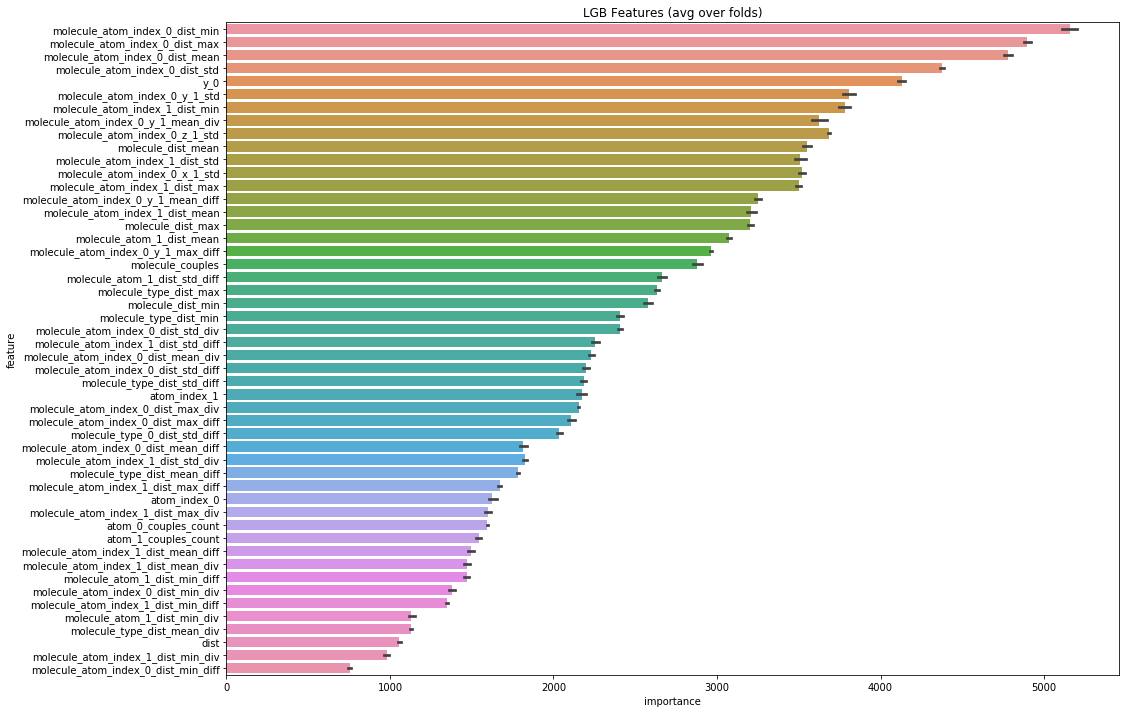

In [18]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

# [500]	training's l1: 1.11007	valid_1's l1: 1.15256

In [ ]:
[
    'molecule_dist_max',
    'molecule_atom_1_dist_mean',
    'molecule_atom_index_0_y_1_max_diff',
    'molecule_couples',
    'molecule_atom_1_dist_std_diff',
    'molecule_type_dist_max',
    'molecule_dist_min',
    'molecule_type_dist_min',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_0_dist_mean_div',
    'molecule_atom_index_1_dist_std_diff',
    'atom_index_1',
    'molecule_atom_index_0_dist_max_div',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_type_0_dist_std_diff',
    'molecule_atom_index_0_dist_mean_diff',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_type_dist_mean_diff',
]

In [ ]:
good_columns = [
    'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_max',
    'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_std',
    'y_0',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_1_dist_min',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_z_1_std',
    'molecule_dist_mean',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_1_dist_max',
    'molecule_atom_index_0_y_1_mean_diff',
    'molecule_atom_index_1_dist_mean',
]

In [19]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('../submissions/sub2.csv', index=False)
sub.head()

id  scalar_coupling_constant
0  4658147        12.361512993735420
1  4658148       196.068743066744275
2  4658149         6.017216616205310
3  4658150       187.301426330745244
4  4658151         6.006984054660421

In [20]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub2.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:15<00:00, 4.34MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 360 ms, sys: 544 ms, total: 904 ms
Wall time: 20.4 s


In [22]:
from time import sleep
sleep(20)
!kaggle competitions submissions -c champs-scalar-coupling

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub2.csv  2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv  2019-06-04 16:51:51  None         complete  0.299        None          


In [20]:
X.isnull().sum()

id                                       0
molecule_name                            0
atom_index_0                             0
atom_index_1                             0
type                                     0
atom_0                                   0
x_0                                      0
y_0                                      0
z_0                                      0
atom_1                                   0
x_1                                      0
y_1                                      0
z_1                                      0
dist                                     0
dist_x                                   0
dist_y                                   0
dist_z                                   0
type_0                                   0
type_1                                   0
molecule_couples                         0
molecule_dist_mean                       0
molecule_dist_median                     0
molecule_dist_min                        0
molecule_di

In [23]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=2000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub2a.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Sat Jun  8 18:37:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.58509	valid_1's l1: 1.89447
[1000]	training's l1: 1.27769	valid_1's l1: 1.77306
[1500]	training's l1: 1.07884	valid_1's l1: 1.71715
[2000]	training's l1: 0.929109	valid_1's l1: 1.6817
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.929109	valid_1's l1: 1.6817
Fold 2 started at Sat Jun  8 18:38:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.57697	valid_1's l1: 1.8863
[1000]	training's l1: 1.2773	valid_1's l1: 1.76772
[1500]	training's l1: 1.07602	valid_1's l1: 1.71005
[2000]	training's l1: 0.928326	valid_1's l1: 1.67621
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.928326	valid_1's l1: 1.67621
Fold 3 started at Sat Jun  8 18:39:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.57968	valid_1's l1: 1.9027

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.213781	valid_1's l1: 0.421137
[1000]	training's l1: 0.123364	valid_1's l1: 0.403759
[1500]	training's l1: 0.0756088	valid_1's l1: 0.397616
[2000]	training's l1: 0.0489244	valid_1's l1: 0.394841
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.0489244	valid_1's l1: 0.394841
CV mean score: -0.9282, std: 0.0061.
Training of type 2
Fold 1 started at Sat Jun  8 18:48:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.745988	valid_1's l1: 0.848759
[1000]	training's l1: 0.618382	valid_1's l1: 0.784298
[1500]	training's l1: 0.536426	valid_1's l1: 0.752174
[2000]	training's l1: 0.475086	valid_1's l1: 0.732873
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.475086	valid_1's l1: 0.732873
Fold 2 started at Sat Jun  8 18:50:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.748642	va

Fold 4 started at Sat Jun  8 19:15:41 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.161444	valid_1's l1: 0.281048
[1000]	training's l1: 0.0998889	valid_1's l1: 0.267082
[1500]	training's l1: 0.0666925	valid_1's l1: 0.2615
[2000]	training's l1: 0.0459436	valid_1's l1: 0.258853
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.0459436	valid_1's l1: 0.258853
Fold 5 started at Sat Jun  8 19:16:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.159512	valid_1's l1: 0.279751
[1000]	training's l1: 0.100237	valid_1's l1: 0.266151
[1500]	training's l1: 0.0672467	valid_1's l1: 0.261057
[2000]	training's l1: 0.0464822	valid_1's l1: 0.258545
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.0464822	valid_1's l1: 0.258545
CV mean score: -1.3496, std: 0.0032.


id  scalar_coupling_constant
0  4658147         6.569018949735424
1  4658148       192.531104906293336
2  4658149         5.488635712045531
3  4658150       184.112878322452502
4  4658151         6.238307645185175

In [24]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub2a.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:58<00:00, 1.15MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 1.38 s, sys: 697 ms, total: 2.08 s
Wall time: 1min 1s


In [25]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          


In [26]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub2b.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Sat Jun  8 19:41:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.58509	valid_1's l1: 1.89447
[1000]	training's l1: 1.27713	valid_1's l1: 1.76987
[1500]	training's l1: 1.07764	valid_1's l1: 1.7133
[2000]	training's l1: 0.928753	valid_1's l1: 1.68058
[2500]	training's l1: 0.810003	valid_1's l1: 1.65795
[3000]	training's l1: 0.712973	valid_1's l1: 1.64237
[3500]	training's l1: 0.632111	valid_1's l1: 1.63049
[4000]	training's l1: 0.562913	valid_1's l1: 1.6211
[4500]	training's l1: 0.503122	valid_1's l1: 1.61381
[5000]	training's l1: 0.452217	valid_1's l1: 1.60851
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.452217	valid_1's l1: 1.60851
Fold 2 started at Sat Jun  8 19:45:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.57697	valid_1's l1: 1.8863
[1000]	training's l1: 1.2773	valid_1's l1: 1.76772
[1500]	training's l1: 1.07565	valid_1's l1:

Fold 2 started at Sat Jun  8 20:10:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.408293	valid_1's l1: 0.917398
[1000]	training's l1: 0.210309	valid_1's l1: 0.892114
[1500]	training's l1: 0.111478	valid_1's l1: 0.882969
[2000]	training's l1: 0.0632624	valid_1's l1: 0.879676
[2500]	training's l1: 0.035745	valid_1's l1: 0.878099
[3000]	training's l1: 0.019872	valid_1's l1: 0.877575
[3500]	training's l1: 0.0111246	valid_1's l1: 0.877336
[4000]	training's l1: 0.00653421	valid_1's l1: 0.877169
Early stopping, best iteration is:
[4248]	training's l1: 0.00520645	valid_1's l1: 0.877114
Fold 3 started at Sat Jun  8 20:10:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.395561	valid_1's l1: 0.91602
[1000]	training's l1: 0.204046	valid_1's l1: 0.886574
[1500]	training's l1: 0.111486	valid_1's l1: 0.879426
[2000]	training's l1: 0.0633988	valid_1's l1: 0.876205
[2500]	training's l1: 0.0360728	valid_1's l1: 0

Fold 3 started at Sat Jun  8 20:27:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.747098	valid_1's l1: 0.85003
[1000]	training's l1: 0.619441	valid_1's l1: 0.785254
[1500]	training's l1: 0.537712	valid_1's l1: 0.754481
[2000]	training's l1: 0.476237	valid_1's l1: 0.735085
[2500]	training's l1: 0.42657	valid_1's l1: 0.721583
[3000]	training's l1: 0.385087	valid_1's l1: 0.711488
[3500]	training's l1: 0.349989	valid_1's l1: 0.7038
[4000]	training's l1: 0.319542	valid_1's l1: 0.698115
[4500]	training's l1: 0.292944	valid_1's l1: 0.693526
[5000]	training's l1: 0.269162	valid_1's l1: 0.689525
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.269162	valid_1's l1: 0.689525
Fold 4 started at Sat Jun  8 20:32:58 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.747903	valid_1's l1: 0.84418
[1000]	training's l1: 0.621383	valid_1's l1: 0.780404
[1500]	training's l1: 0.539181	valid_1's l1: 

Fold 4 started at Sat Jun  8 21:18:25 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.829174	valid_1's l1: 0.913101
[1000]	training's l1: 0.702747	valid_1's l1: 0.841546
[1500]	training's l1: 0.622037	valid_1's l1: 0.80453
[2000]	training's l1: 0.561641	valid_1's l1: 0.78174
[2500]	training's l1: 0.512152	valid_1's l1: 0.765343
[3000]	training's l1: 0.470747	valid_1's l1: 0.753408
[3500]	training's l1: 0.434477	valid_1's l1: 0.743345
[4000]	training's l1: 0.4028	valid_1's l1: 0.735567
[4500]	training's l1: 0.374671	valid_1's l1: 0.729471
[5000]	training's l1: 0.349725	valid_1's l1: 0.724285
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.349725	valid_1's l1: 0.724285
Fold 5 started at Sat Jun  8 21:24:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.828104	valid_1's l1: 0.911431
[1000]	training's l1: 0.70104	valid_1's l1: 0.838995
[1500]	training's l1: 0.620211	valid_1's l1: 

id  scalar_coupling_constant
0  4658147         5.698773512149136
1  4658148       193.099534343141073
2  4658149         5.571093461035416
3  4658150       184.148645478728781
4  4658151         6.021901072053419

In [27]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub2b.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:18<00:00, 3.63MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 431 ms, sys: 547 ms, total: 978 ms
Wall time: 21.4 s


In [28]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          
